<a href="https://colab.research.google.com/github/duttagoutam/CarDamageDetection/blob/main/05_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline

In [1]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [2]:
import keras; 
print(keras.__version__)

2.4.3


In [3]:
from flask import Flask

app = Flask(__name__)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Step5:
### Call all the models that is created by the previous steps and test the validity of the model.

In [2]:
import os
import json
import h5py
import urllib.request
import numpy as np
import pickle as pk
from IPython.display import Image, display, clear_output

In [3]:
from keras.models import Sequential, load_model
from keras.utils.data_utils import get_file
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.data_utils import get_file

## Models

In [5]:
location = '/content/drive/My Drive/App/CarDamage/data'
model1 = VGG16(weights = 'imagenet')
model2 = load_model('/content/drive/My Drive/App/CarDamage/data/ft_model.h5')
model3 = load_model('/content/drive/My Drive/App/CarDamage/data2a/ft_model.h5')
model4 = load_model('/content/drive/My Drive/App/CarDamage/data3a/ft_model.h5')

In [6]:
with open(location+'/vgg16_cat_list.pk', 'rb') as f:
    cat_list = pk.load(f)

## Pipe 1: check for car

In [7]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [8]:
def prepare_image_224(img_path):
    #urllib.request.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [9]:
def pipe1(img_224, model):
    print("Ensuring entered picture is a car...")
    out = model.predict(img_224)
    preds = get_predictions(out, top=5)
    for pred in preds[0]:
        if pred[0:2] in cat_list:
            return True #"Successful. Proceeding to damage assessment..."
    return False #"The entered image is a not a car. Please try again. Consider a different angle or lighting."

## Pipe 2: checking for damage

In [10]:
def prepare_img_256(img_path):
    #urllib.request.urlretrieve(img_path, 'save.jpg')
    img = load_img(img_path, target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    return x

In [11]:
def pipe2(img_256, model):
    print("Validating that damage exists....")
    pred = model.predict(img_256)
    if(pred[0][0]<=0.5):
        return True #print("Validation complete - proceed to location and severity determination")
    else:
        return False
        #print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        #print ("Hint: Try zooming in/out, using a different angle or different lighting")      

## Pipe 3: location and severity assessment

In [12]:
def pipe3_loc(img_256, model):
    print("Determining location of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'front', 1:'rear', 2:'side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Result: damage to {} of vehicle".format(d[key]))
    print("Location assessment complete.")

In [13]:
def pipe3_sev(img_256, model):
    print("Determining severity of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'minor', 1:'moderate', 2:'severe'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Result:{} damage".format(d[key]))
    print("Severity assessment complete.")

## Complete Pipeline

In [16]:
def pipeline(img_path): 
    while True:
        #print("Submit image link (or type 'exit' to quit)") 
        #img_path = input("Upload Image File Here:") 
        #if img_path == 'exit': 
        #    return None 
        #clear_output()   
        img_224 = prepare_image_224(img_path) 
        p1 = pipe1(img_224, model1) 
        display(Image(img_path, width=300))  
        if p1 is False:
            print("The entered image is a not a car. Please try again. Consider a different angle or lighting.") 
            break 
        else: 
            print("Successful. Proceeding to damage assessment...") 

        img_256 = prepare_img_256(img_path) 
        p2 = pipe2(img_256, model2) 
        
        if p2 is False: 
            print ("Are you sure that your car is damaged? Please submit another picture of the damage.") 
            print ("Hint: Try zooming in/out, using a different angle or different lighting")       
            break 
        else: 
            print("Validation complete - proceed to location and severity determination") 

        x = pipe3_loc(img_256, model3) 
        y = pipe3_sev(img_256, model4) 
        break 

Ensuring entered picture is a car...


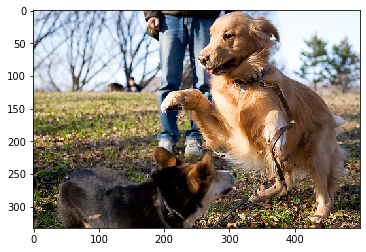

The entered image is a not a car. Please try again. Consider a different angle or lighting.


In [17]:
pipeline('/content/drive/My Drive/App/CarDamage/data/dog.JPEG')

Ensuring entered picture is a car...


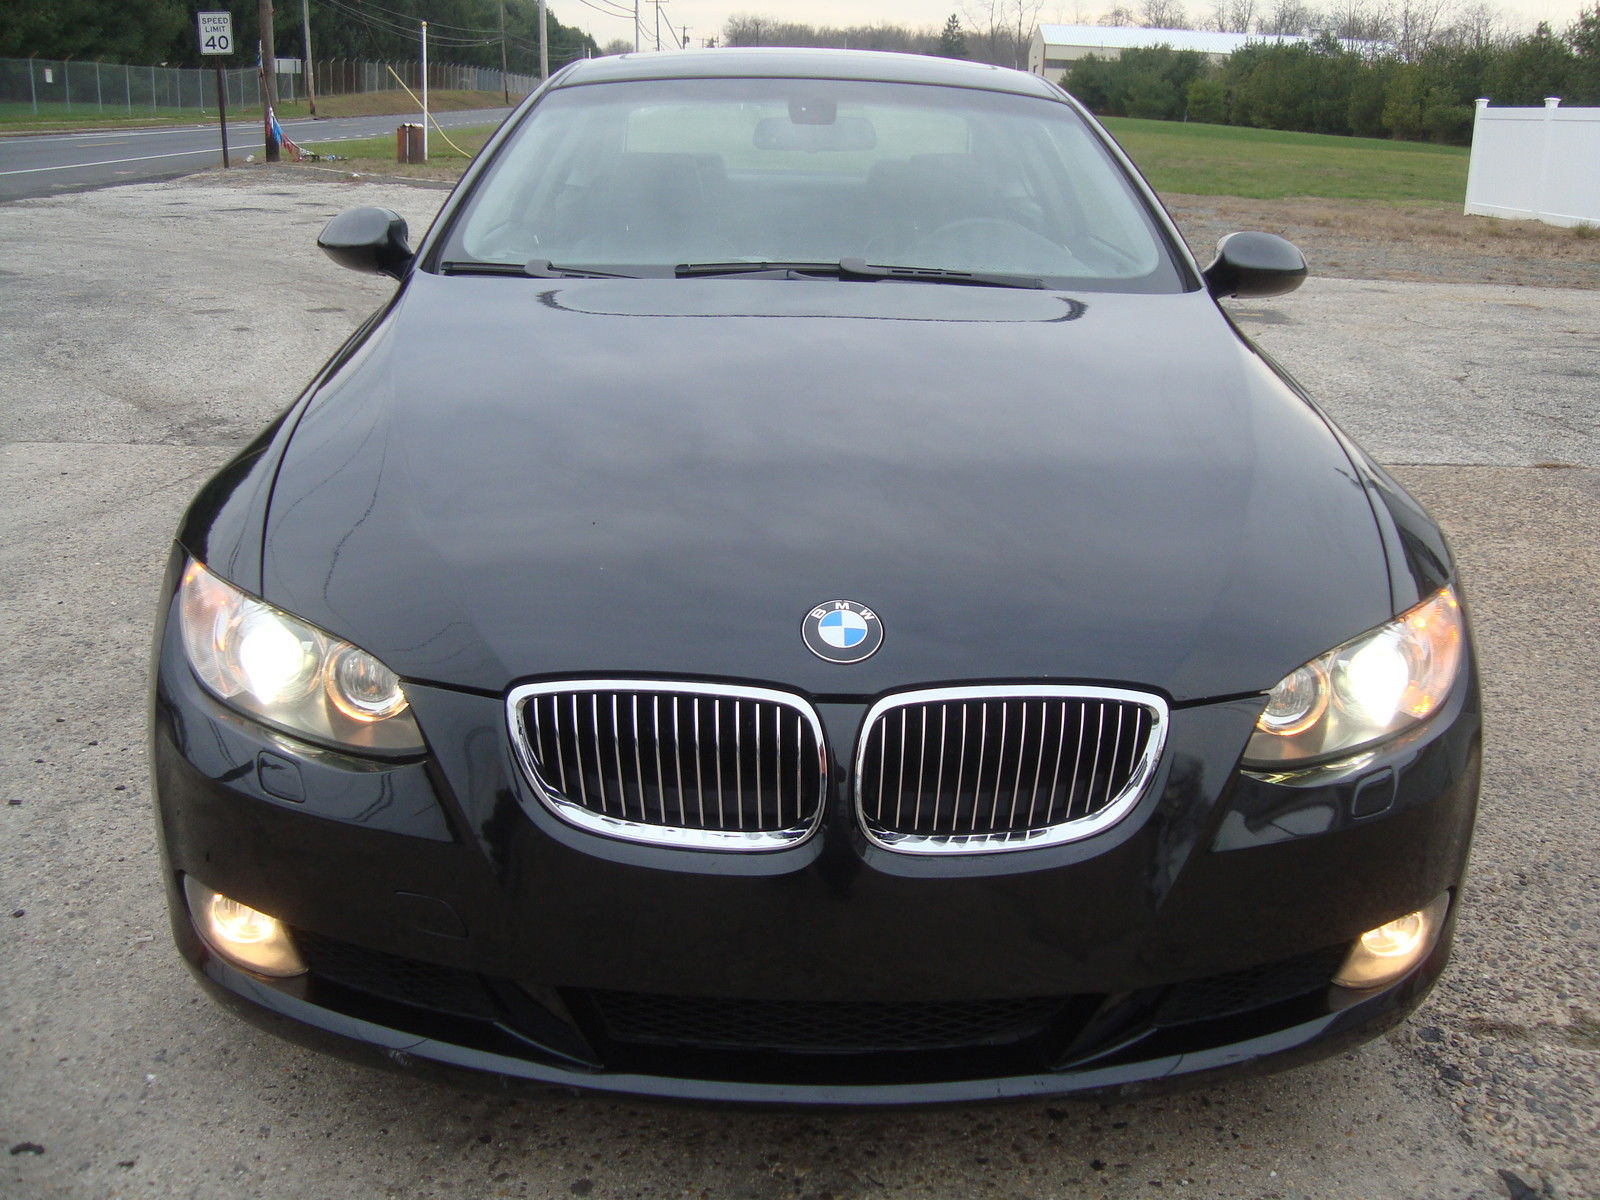

Successful. Proceeding to damage assessment...
Validating that damage exists....
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [18]:
#pipeline('http://wrecked-sport-cars-for-sale.com/wp-content/wrecked-sport-cars-for-sale.com/2016/01/2009-bmw-328xi-coupe-salvage-rebuildable-wrecked-for-sale-2016-01-10-1.jpg')
pipeline('/content/drive/My Drive/App/CarDamage/data/WholeCar.jpg')

Ensuring entered picture is a car...


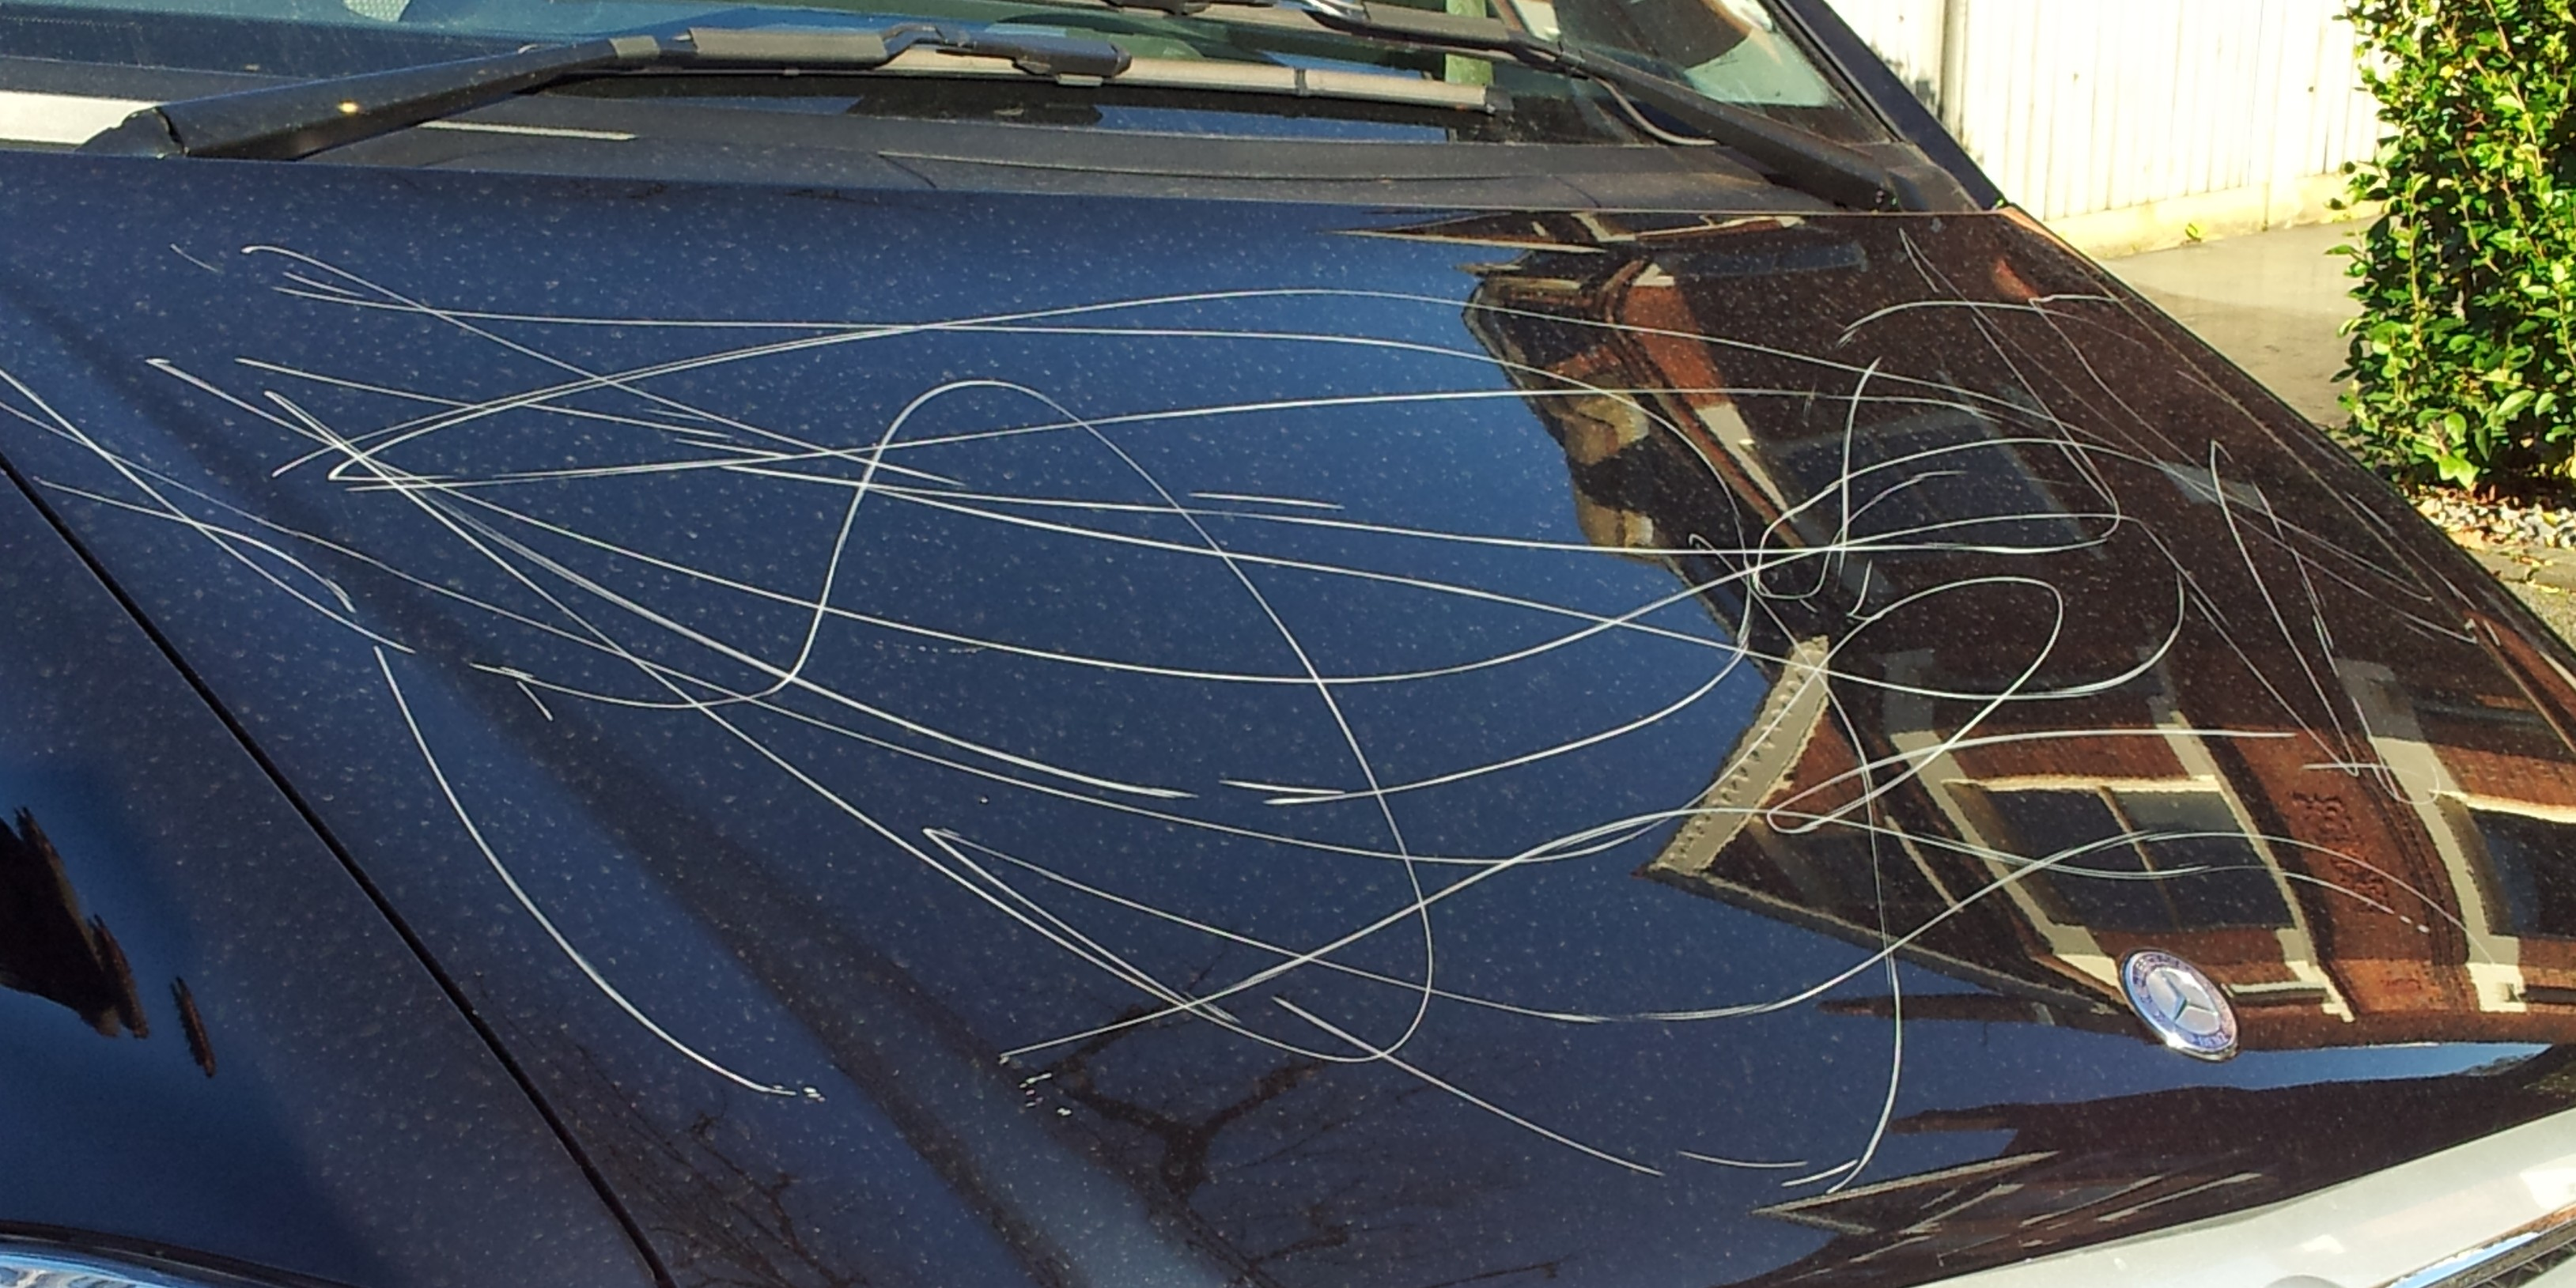

Successful. Proceeding to damage assessment...
Validating that damage exists....
Validation complete - proceed to location and severity determination
Determining location of damage...
Result: damage to side of vehicle
Location assessment complete.
Determining severity of damage...
Result:minor damage
Severity assessment complete.


In [20]:
#pipeline('http://www.reshareable.tv/files/2014/06/6177_8_site_clear.jpeg')
pipeline('/content/drive/My Drive/App/CarDamage/data/CarDamageTest1.jpg')

Ensuring entered picture is a car...


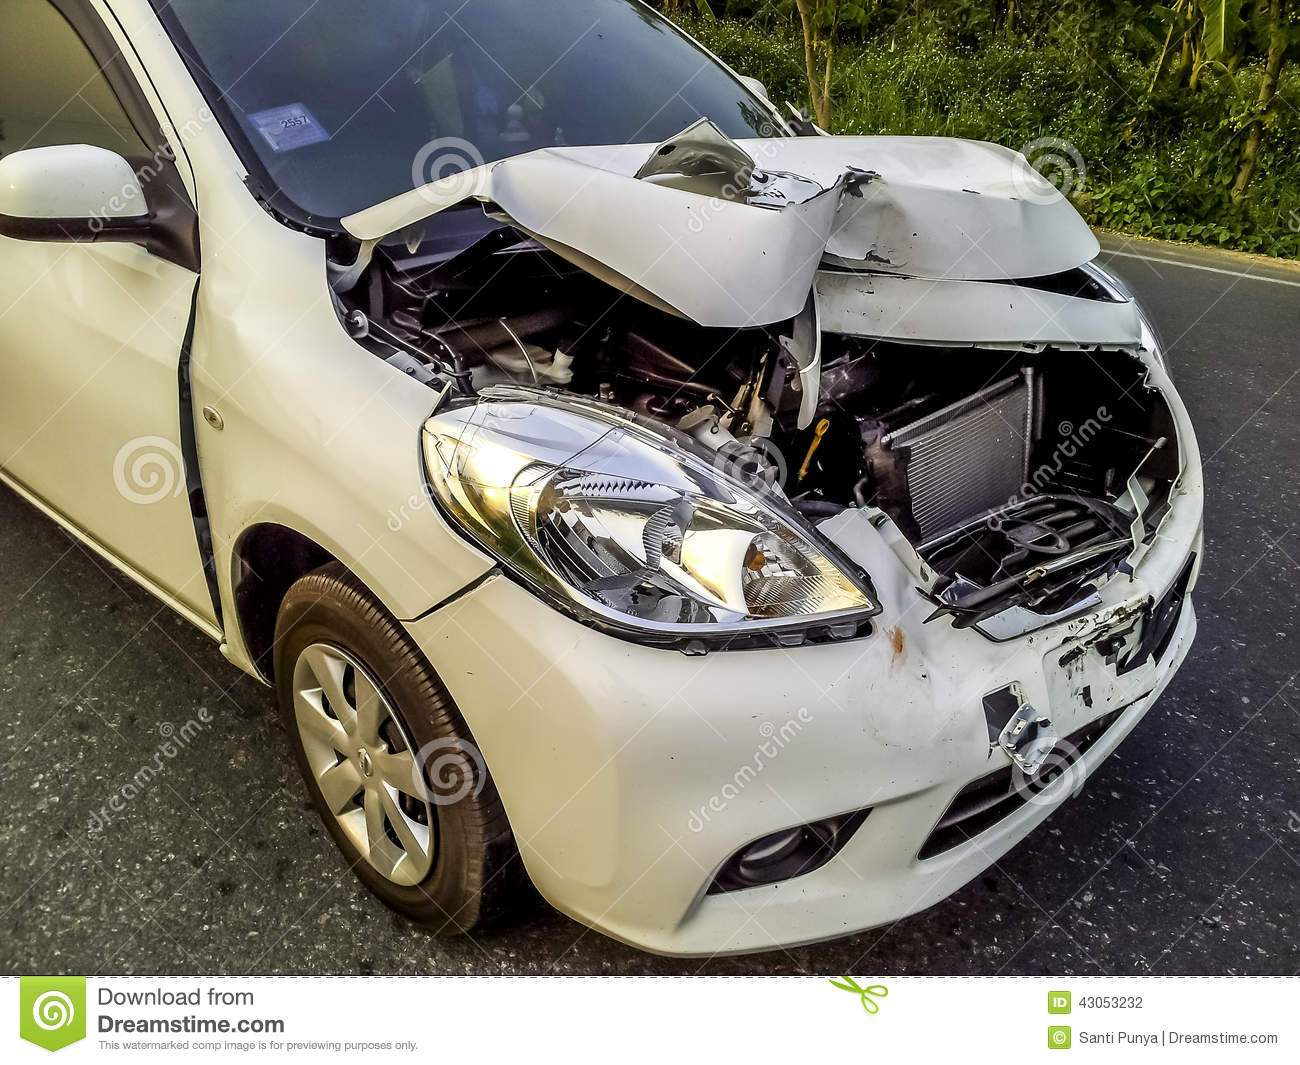

Successful. Proceeding to damage assessment...
Validating that damage exists....
Validation complete - proceed to location and severity determination
Determining location of damage...
Result: damage to front of vehicle
Location assessment complete.
Determining severity of damage...
Result:severe damage
Severity assessment complete.


In [21]:
#pipeline('https://thumbs.dreamstime.com/z/damage-car-front-side-accident-43053232.jpg')
pipeline('/content/drive/My Drive/App/CarDamage/data/CarDamageTest2.jpg')

Ensuring entered picture is a car...


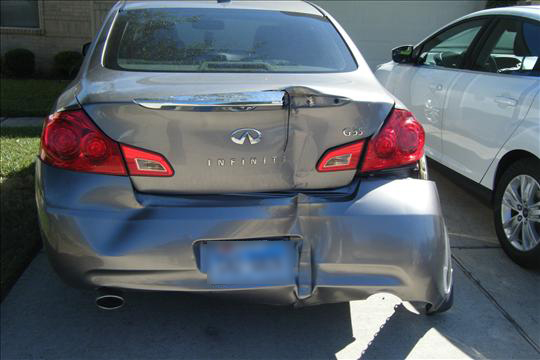

Successful. Proceeding to damage assessment...
Validating that damage exists....
Validation complete - proceed to location and severity determination
Determining location of damage...
Result: damage to rear of vehicle
Location assessment complete.
Determining severity of damage...
Result:moderate damage
Severity assessment complete.


In [22]:
#pipeline('https://drndata.com/wp-content/uploads/2016/03/car.jpg')
pipeline('/content/drive/My Drive/App/CarDamage/data/CarDamageTest3.jpg')

Ensuring entered picture is a car...


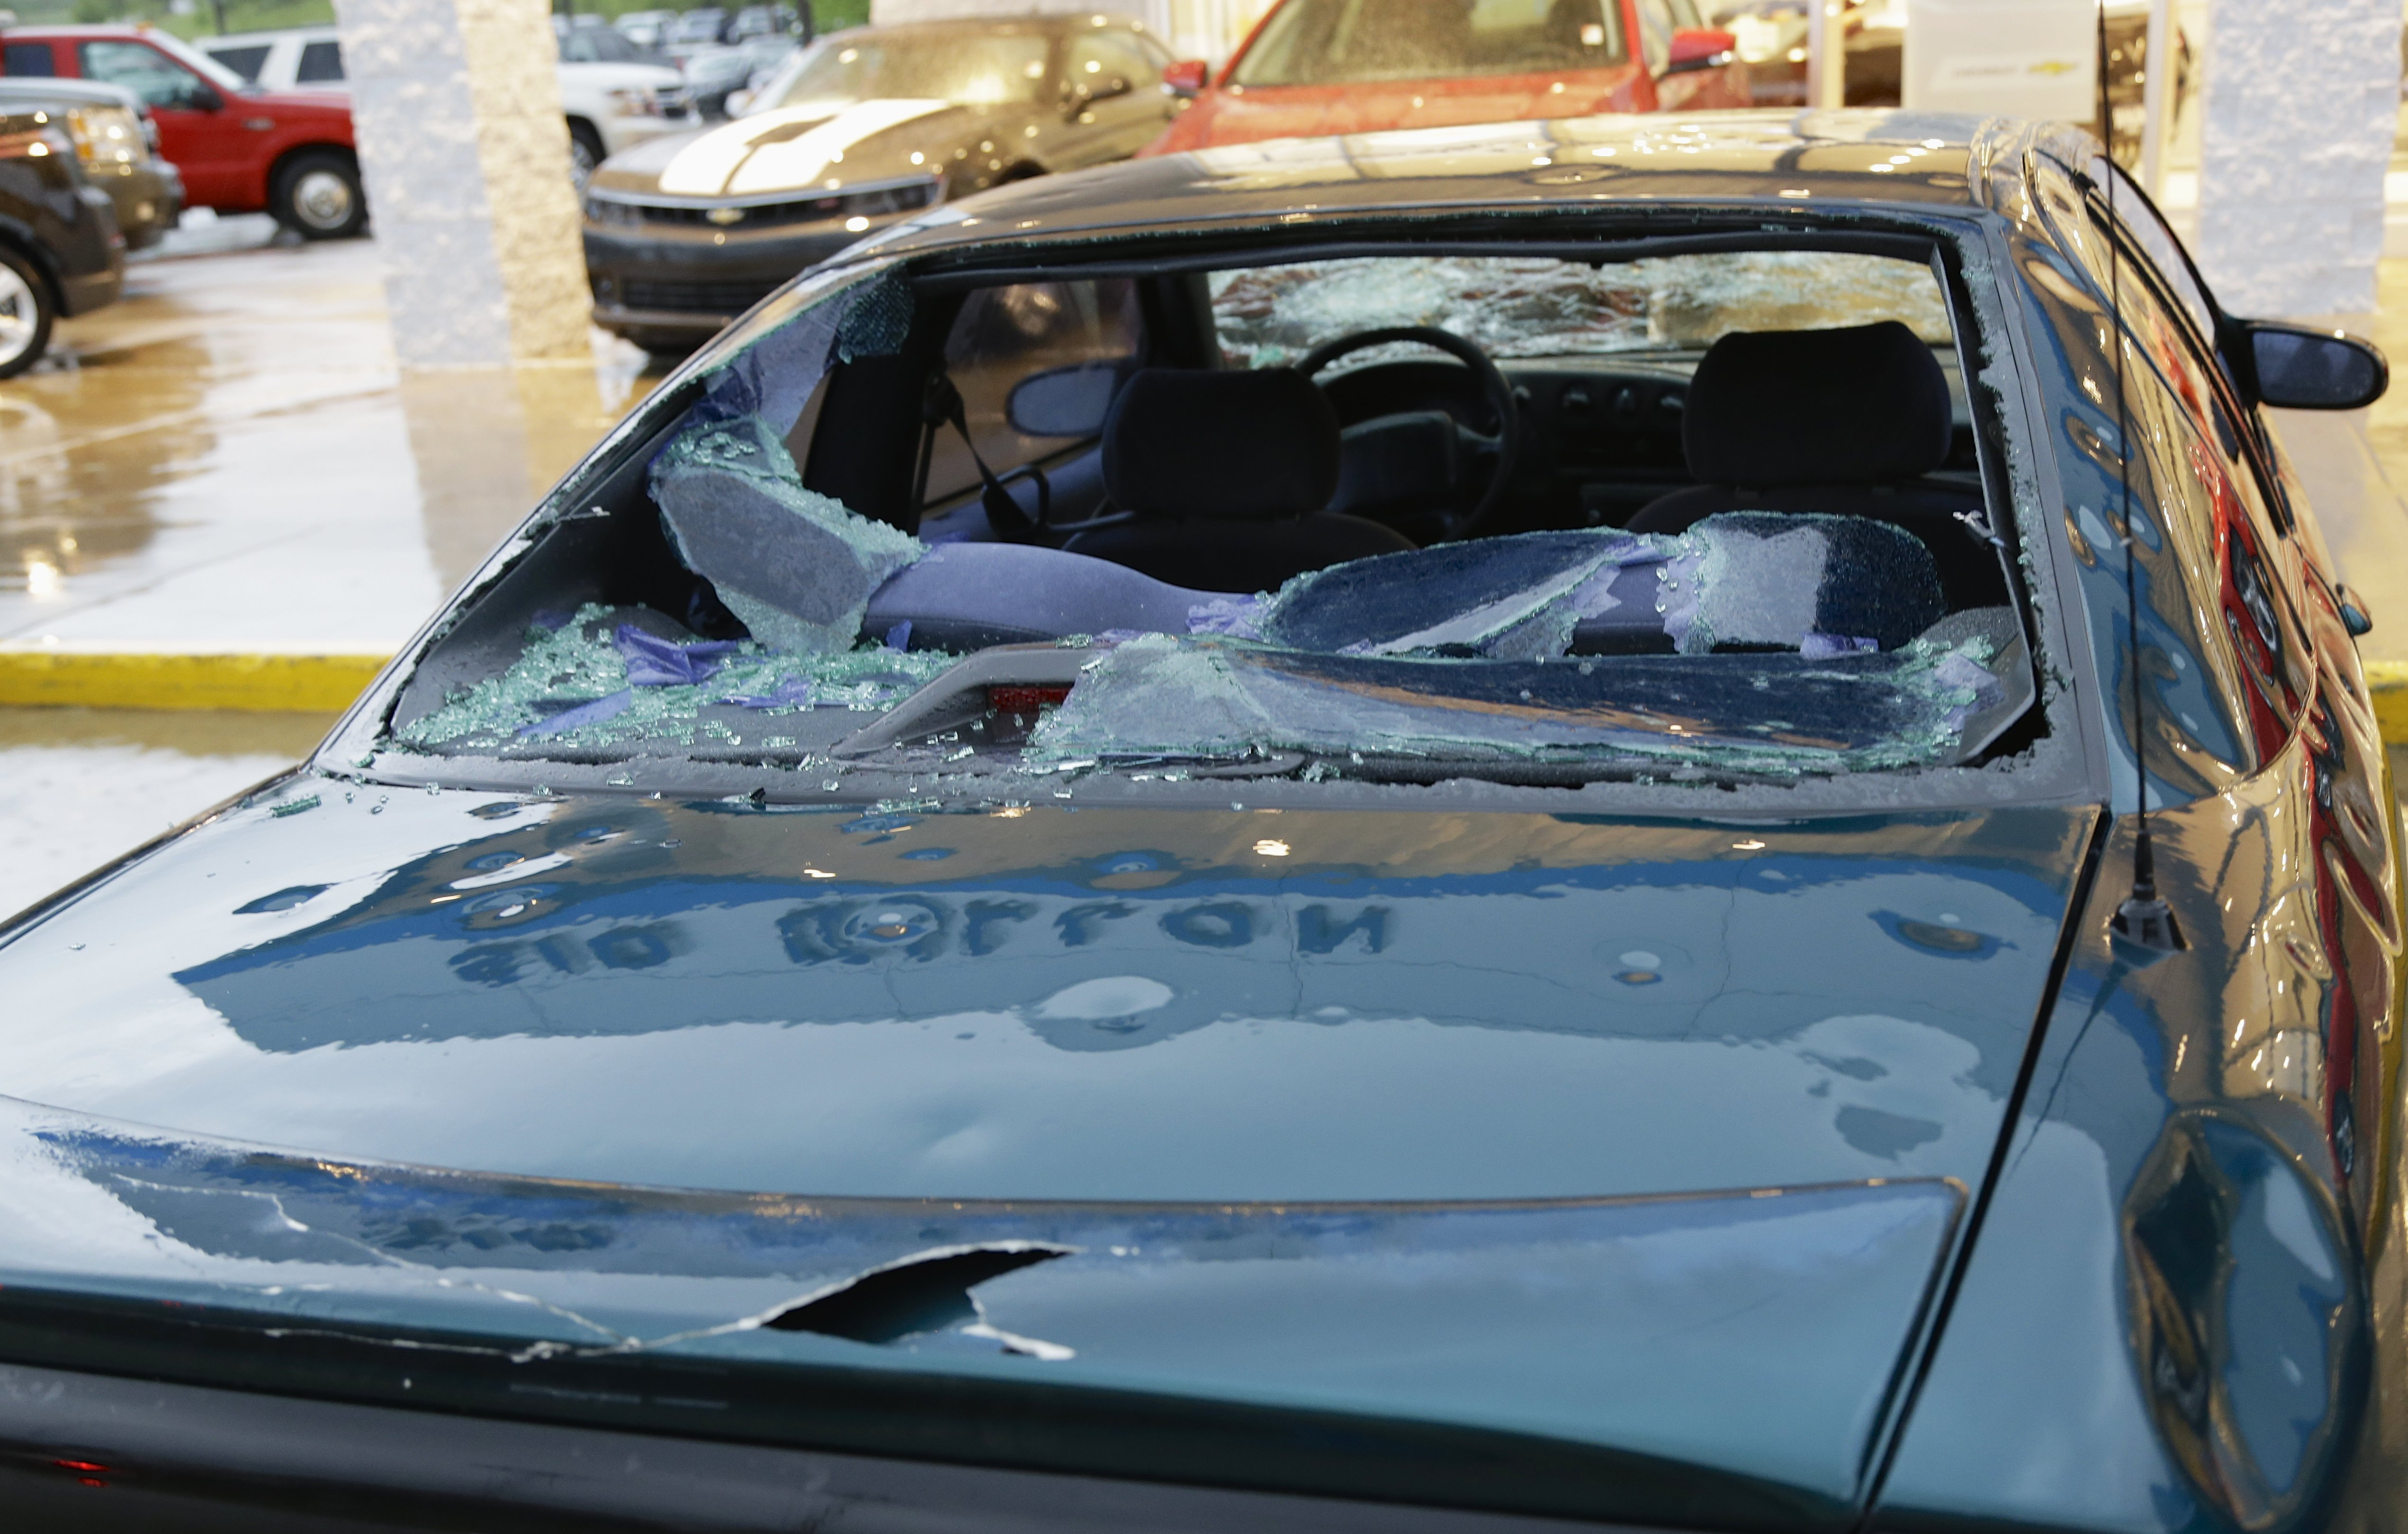

Successful. Proceeding to damage assessment...
Validating that damage exists....
Validation complete - proceed to location and severity determination
Determining location of damage...
Result: damage to rear of vehicle
Location assessment complete.
Determining severity of damage...
Result:severe damage
Severity assessment complete.


In [23]:
#pipeline('https://timedotcom.files.wordpress.com/2014/06/hail-damage-car-2.jpg?quality=85')
pipeline('/content/drive/My Drive/App/CarDamage/data/CarDamageTest4.jpg')

Ensuring entered picture is a car...


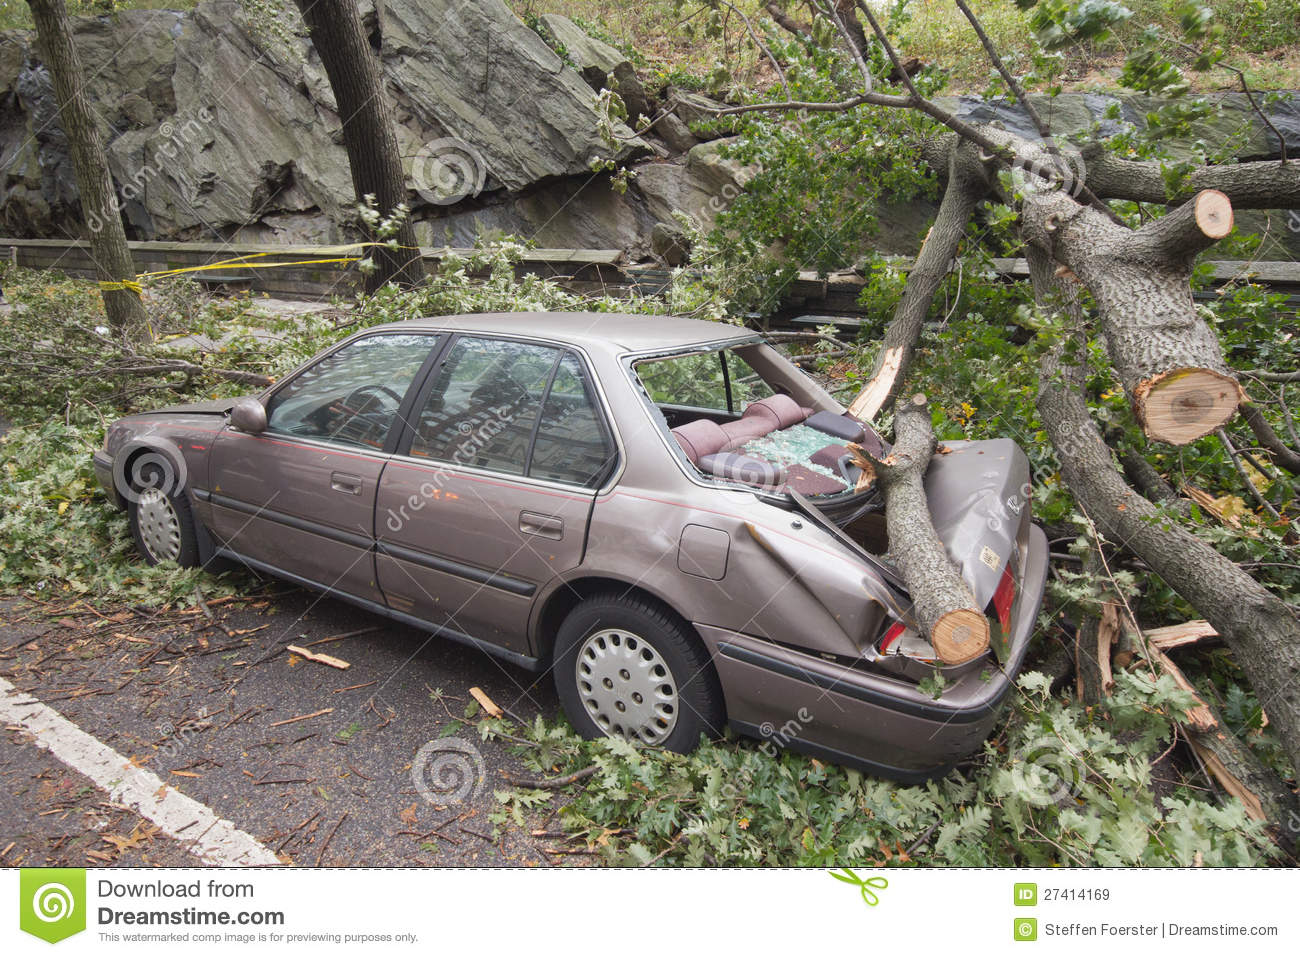

Successful. Proceeding to damage assessment...
Validating that damage exists....
Validation complete - proceed to location and severity determination
Determining location of damage...
Result: damage to front of vehicle
Location assessment complete.
Determining severity of damage...
Result:severe damage
Severity assessment complete.


In [24]:
#pipeline('https://thumbs.dreamstime.com/z/car-damaged-hurricane-sandy-27414169.jpg')
pipeline('/content/drive/My Drive/App/CarDamage/data/CarDamageTest5.jpg')